In [ ]:
!pip install leafmap datasets git+https://github.com/ESA-PhiLab/Major-TOM.git

  Cloning https://github.com/ESA-PhiLab/Major-TOM.git to /tmp/pip-req-build-5_tb3y_7
  Running command git clone --filter=blob:none --quiet https://github.com/ESA-PhiLab/Major-TOM.git /tmp/pip-req-build-5_tb3y_7
  Resolved https://github.com/ESA-PhiLab/Major-TOM.git to commit c7ef3440f29e314ae1c7dc564234693c7f0f9e99
  Preparing metadata (setup.py) ... done
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.7/213.7 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━

In [ ]:
!rm -r ./data

rm: cannot remove './data': No such file or directory


## **Scratch Pad**

In [ ]:
S1 = MajorTOMDataset.load_metadata('/content/drive/MyDrive/Preparing Dataset/metadata_S1RTC_with_forest_ratio.parquet')
S2 = MajorTOMDataset.load_metadata('/content/drive/MyDrive/Preparing Dataset/metadata_S2L2A_with_forest_ratio.parquet')

In [ ]:
row_num = 15000
filter_download(S1.iloc[row_num:row_num+1], by_row=True, local_dir='./data/', verbose=True, source_name='S1RTC', for_S1=True)

Starting download of 1 parquet files.


In [ ]:
ds_S1 = MajorTOM(S1.iloc[row_num:row_num+1], './data/S1RTC', tif_bands = ['vv', 'vh'])

In [ ]:
ds_S1[0].keys()

dict_keys(['meta', 'vv', 'vh', 'thumbnail'])

In [ ]:
ds_S1[0]['vh'].shape

torch.Size([1068, 1, 1068])

In [ ]:
ds_S1[0]['vh'].clip(0, 1).min()

tensor(0.0004)

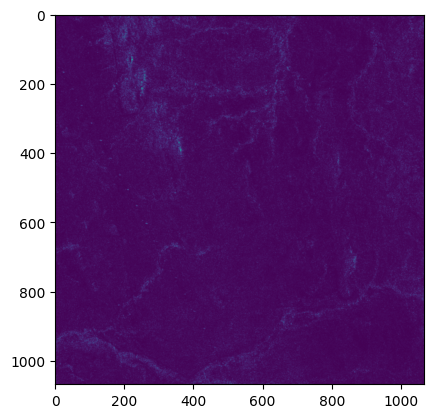

In [ ]:
plt.imshow(ds_S1[0]['vh'].clip(0, 1).permute(1,2,0).permute(1, 2, 0))

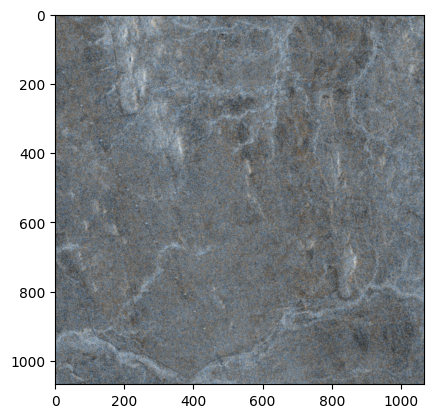

In [ ]:
plt.imshow(ds_S1[0]['thumbnail'].permute(1, 2, 0))

In [ ]:
filter_download(S2.iloc[0:1], by_row=True, local_dir='./data/', verbose=True, source_name='S2L2A')

Starting download of 1 parquet files.


In [ ]:
ds = MajorTOM(S2.iloc[0:1], './data/S2L2A', tif_bands=['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12'])
ds[0].keys()

dict_keys(['meta', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12', 'thumbnail'])

In [ ]:
x = 'B08'
ds[0][x].float().min(), ds[0][x].float().max()

(tensor(3564.), tensor(10728.))

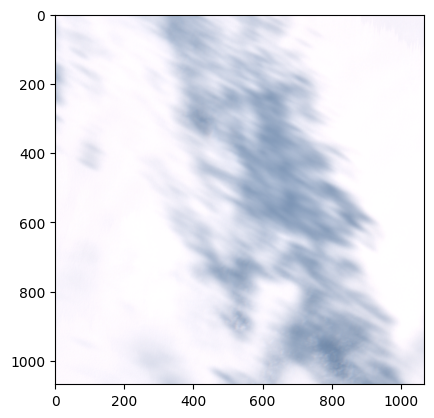

In [ ]:
plt.imshow(torch.stack([ds[0]['B04'].permute(2, 0, 1), ds[0]['B03'].permute(2, 0, 1), ds[0]['B02'].permute(2, 0, 1)]).squeeze().permute(1, 2, 0)/10000)

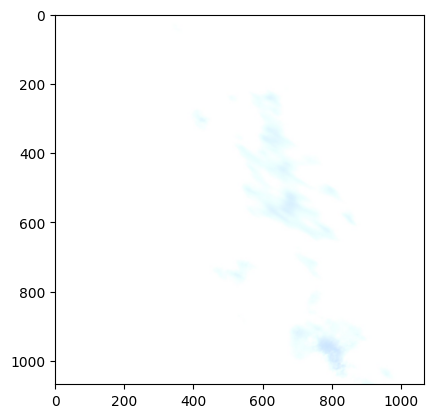

In [ ]:
plt.imshow(ds[0]['thumbnail'].permute(1, 2, 0))

In [ ]:
ds[0]['B04'].permute(1, 2, 0).shape

torch.Size([1, 1068, 1068])

In [ ]:
# torchvision tensor resize to 1024 x 1024
ds[0]['B04'].shape
image = transforms.Resize((1024, 1024))(ds[0]['B04'].permute(1, 2, 0))

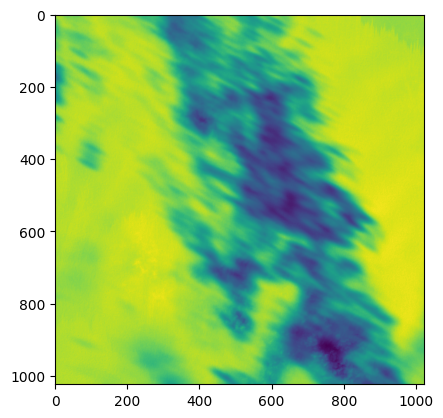

In [ ]:
plt.imshow(image.permute(1, 2, 0).cpu().numpy())

In [ ]:
row = MajorTOM(S2.iloc[120:121], './data/S2L2A', tif_bands=['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12'])[0]
del row['meta']
del row['thumbnail']
# convert UInt_16 tensors bands in 'row' to floats and normalize them
for key in row.keys():
    row[key] = row[key].float()
    #normalize the Sentinel 2 bands
    row[key] = row[key]/10000 if key[0] == 'B' else row[key] # values should not exceed 10000 but reflextance can be higher than 1. https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l2a/#units
    row[key] = row[key].clip(0, 1000) # should not be negative
    # permute into torch order (1, 1068, 1068) and resize the band to 1024 by 1024
    row[key] = row[key].permute(1, 2, 0)
    row[key] = transforms.Resize((1024, 1024))(row[key])
#stack them into a single tensor in the order of ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12', 'vv', 'vh' (if using S1)]
image = torch.concat([
    row['B01'], row['B02'], row['B03'],
    row['B04'], row['B05'], row['B06'], row['B07'], row['B08'],
    row['B8A'], row['B09'], row['B11'], row['B12']
])

In [ ]:
row['B01']

tensor([[[0.9795, 0.9795, 0.9795,  ..., 0.9779, 0.9779, 0.9779],
         [0.9795, 0.9795, 0.9795,  ..., 0.9779, 0.9779, 0.9779],
         [0.9795, 0.9795, 0.9795,  ..., 0.9779, 0.9779, 0.9779],
         ...,
         [0.9744, 0.9744, 0.9744,  ..., 0.9628, 0.9628, 0.9628],
         [0.9744, 0.9744, 0.9744,  ..., 0.9628, 0.9628, 0.9628],
         [0.9744, 0.9744, 0.9744,  ..., 0.9628, 0.9628, 0.9628]]])

In [ ]:
S2.iloc[120]['product_id']

'S2B_MSIL2A_20210204T154319_N0500_R125_T02CNP_20230530T023544'

In [ ]:
S2.iloc[120]['grid_cell'].split('_')[0]

'921D'

In [ ]:
S2.iloc[120]['grid_cell']

'921D_234L'

## **Dataset.py**

In [3]:
from majortom import *

In [41]:
def filter_download(df, local_dir, source_name, by_row = False, verbose = False, tif_columns=None, for_S1 = False):
    """Downloads and unpacks the data of Major-TOM based on a metadata dataframe
    Modified to support S1RTC data too.
    Args:
        df (geopandas dataframe): Metadata dataframe
        local_dir (str or Path) : Path to the where the data is to be stored locally
        source_name (str) : Name alias of the resulting dataset
        by_row (bool): If True, it will access individual rows of parquet via http - otherwise entire parquets are downloaded temporarily
        verbose (bool) : option for potential internal state printing
        tif_columns (list of str) : Optionally specified columns to be downloaded as .tifs, e.g. ['B04', 'B03', 'B02']
        for_S1 (bool) : Set to true if downloading S1RTC data
    Returns:
        None

    """

    if isinstance(local_dir, str):
        local_dir = Path(local_dir)

    temp_file = local_dir / 'temp.parquet'

    # identify all parquets that need to be downloaded (group them)
    urls = df.parquet_url.unique()
    print('Starting download of {} parquet files.'.format(len(urls))) if verbose else None

    iter = tqdm(urls, desc='Downloading and unpacking...') if verbose else urls
    for url in iter:
        # identify all relevant rows
        rows = df[df.parquet_url == url].parquet_row.unique()

        if not by_row: # (downloads entire parquet)
            # download a temporary file
            temp_path, http_resp = urllib.request.urlretrieve(url, temp_file)
        else:
            f=fsspec.open(url)
            temp_path = f.open()

        # populate the bands
        with pq.ParquetFile(temp_path) as pf:
            for row_idx in rows:
                table = pf.read_row_group(row_idx)

                product_id = table['product_id'][0].as_py()
                grid_cell = table['grid_cell'][0].as_py()
                row = grid_cell.split('_')[0]

                dest = local_dir / Path("{}/{}/{}/{}".format(source_name, row, grid_cell, product_id))
                dest.mkdir(exist_ok=True, parents=True)
                if for_S1:
                  columns = ['vv', 'vh']
                else:
                  columns = [col for col in table.column_names if col[0] == 'B'] + ['cloud_mask'] if tif_columns is None else tif_columns
                # tifs
                for col in columns:
                    print('Downloading {} to {}'.format(col, dest/f"{col}.tif")) if verbose else None
                    with open(dest / "{}.tif".format(col), "wb") as f:
                        # Write bytes to file
                        f.write(table[col][0].as_py())

                # thumbnail (png)
                col = 'thumbnail'
                with open(dest / "{}.png".format(col), "wb") as f:
                    # Write bytes to file
                    f.write(table[col][0].as_py())
        if not by_row:
            # remove downloaded file
            os.remove(temp_path)
        else:
            f.close()

In [186]:
import torch
import pandas as pd
import pyarrow.parquet as pq
from torch.utils.data import Dataset
import warnings
import numpy as np
import shutil
from torchvision import transforms
import random
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

class MajorTOMDataset(Dataset):
    def get_indices(image):
        bands = {
            "ndvi": (image[7, :, :] - image[3, :, :]) / (image[7, :, :] + image[3, :, :] + 1e-7),
            "evi": 2.5 * (image[7, :, :] - image[3, :, :]) / (image[7, :, :] + 6 * image[3, :, :] - 7.5 * image[1, :, :] + 1),
            "savi": 1.5 * (image[7, :, :] - image[3, :, :]) / (image[7, :, :] + image[3, :, :] + 0.5),
            "msavi": 0.5 * (2 * image[7, :, :] + 1 - np.sqrt((2 * image[7, :, :] + 1) ** 2 - 8 * (image[7, :, :] - image[3, :, :]))),
            "ndmi": (image[7, :, :] - image[10, :, :]) / (image[7, :, :] + image[10, :, :] + 1e-7),
            "nbr": (image[7, :, :] - image[11, :, :]) / (image[7, :, :] + image[11, :, :] + 1e-7),
            "nbr2": (image[10, :, :] - image[11, :, :]) / (image[10, :, :] + image[11, :, :] + 1e-7),
        }
        for name in bands:
            value = torch.nan_to_num(bands[name]).unsqueeze(0)
            image = torch.cat([image, value], dim=0)
        return image

    def load_metadata(path):
        '''
        Use this function to load metadata instead of the metadata_from_url(...) provided by Major-TOM mantainers
        '''
        df = pd.read_parquet(path)
        df['timestamp'] = pd.to_datetime(df.timestamp)
        gdf = gpd.GeoDataFrame(
            df, geometry=gpd.points_from_xy(df.centre_lon, df.centre_lat), crs=df.crs.iloc[0].replace("EPSG:EPSG:", "EPSG:")
        )
        return gdf


    def __init__(self, S2L2A_metadata_path, S1RTC_metadata_path = None, min_forest_ratio = 0, max_cloud_cover = 0.1, use_S1RTC = True, stream = True, n_sample_splits = 2, keep_cache = False, bands = None, normalize = False, transform = None, verbose = False):
        '''
        MajorTOMDataset is a dataset class that loads data from the Major-TOM dataset, using the modified metadata including forest ratio.
        PLEASE NOTE:
            SET BATCH SIZE to n_sample_splits^2. So if you choose n_sample_splits = 4, then set batch size to 16. THE PERFORMANCE WILL SUFFER IF YOU DO NOT DO THIS.
            The dataset is streamed from the cloud, and not downloaded to a local directory as of current moment. Functionality may be added as needed.
        List of Bands Corresponding to their index in the image tensor:
              0: 'B01',
              1: 'B02',
              2: 'B03',
              3: 'B04',
              4: 'B05',
              5: 'B06',
              6: 'B07',
              7: 'B08',
              8: 'B8A',
              9: 'B09',
              10: 'B11',
              11: 'B12,
              12: 'vv',
              13: 'vh',
              14: 'ndvi',
              15: 'evi',
              16: 'savi',
              17: 'msavi',
              18: 'ndmi',
              19: 'nbr',
              20: 'nbr2',
              21: 'cloud_mask'
        Args:
            S2L2A_metadata_path (str): Path to the S2L2A metadata
            S1RTC_metadata_path (str): Path to the S1RTC metadata
            min_forest_ratio (float): Minimum forest ratio. Default 0
            max_cloud_cover (float): Maximum cloud cover. Default 0.1
            use_S1RTC (bool): If True, use S1RTC data. If False, use only S2L2A data
            stream (bool): If True, the data is streamed from the cloud. If False, the data is downloaded to a local directory (not implemented yet)
            n_sample_splits (int): Default is 2. A value of n will give n^2 images per sample and 1024/n x 1024/n pixels per image
            keep_cache (bool): Set to False by default. Deletes cached data when it is retrieved if set to False. Only set to True if you have enough storage to host the entire dataset (>30TB)
            bands (list of int):
            [
              0: 'B01',
              1: 'B02',
              2: 'B03',
              3: 'B04',
              4: 'B05',
              5: 'B06',
              6: 'B07',
              7: 'B08',
              8: 'B8A',
              9: 'B09',
              10: 'B11',
              11: 'B12,
              12: 'cloud_mask',
              13: 'ndvi',
              14: 'evi',
              15: 'savi',
              16: 'msavi',
              17: 'ndmi',
              18: 'nbr',
              19: 'nbr2',
              20: 'vv',
              21: 'vh',
            ]
            normalize (bool): If True, normalize each channel of the image to [0, 1]
            tranform (torchvision.transforms): A torchvision transform to apply to the image
            verbose (bool): Option for potential internal state printing
        '''
        # Folder Names
        self.S1_Source = 'S1RTC'
        self.S2_Source = 'S2L2A'

        self.use_S1RTC = use_S1RTC
        self.S2L2A_metadata = MajorTOMDataset.load_metadata(S2L2A_metadata_path)
        if self.use_S1RTC:
          self.S1RTC_metadata = MajorTOMDataset.load_metadata(S1RTC_metadata_path)
        self.min_forest_ratio = min_forest_ratio
        self.bands = bands
        self.stream = stream
        if not stream:
            raise NotImplementedError("Downloading to local directory is not implemented yet")

        self.n_sample_splits = n_sample_splits
        self.images_per_sample = n_sample_splits**2
        self.current_sample_number = -1

        self.keep_cache = keep_cache
        if self.keep_cache:
          warnings.warn("Only set 'keep_cache' to True if you have enough storage to host the entire dataset (>30TB)")

        self.normalize = normalize
        self.transform = transform

        self.verbose = verbose

        # Filter out samples with forest ratio less than min_forest_ratio and greater than max_cloud_cover
        self.S2L2A_metadata = self.S2L2A_metadata[self.S2L2A_metadata['forest_ratio'] > min_forest_ratio]
        self.S2L2A_metadata = self.S2L2A_metadata[self.S2L2A_metadata['cloud_cover'] <= max_cloud_cover]
        self.S2L2A_metadata = self.S2L2A_metadata[self.S2L2A_metadata['nodata'] == 0]
        self.S2L2A_metadata = self.S2L2A_metadata.reset_index(drop=True)
        if self.use_S1RTC:
          self.S1RTC_metadata = self.S1RTC_metadata[self.S1RTC_metadata['nodata'] == 0]
          self.S1RTC_metadata = self.S1RTC_metadata.reset_index(drop=True)

        if self.use_S1RTC:
          warnings.warn("The S1-RTC has data available for fewer grid cells than the S2-L2A dataset. Using the S1-RTC for training would waste over 780k grid cells over the globe.")
          # remove all rows in S2L2A that aren't in S1RTC
          self.S2L2A_metadata = self.S2L2A_metadata[self.S2L2A_metadata['grid_cell'].isin(self.S1RTC_metadata['grid_cell'])]

          # remove duplicates. I was avoiding doing this since duplicates had different paraquet rows, but having duplicates makes it impossible to match to corresponding S1RTC rows
          self.S2L2A_metadata = self.S2L2A_metadata.drop_duplicates(subset=['grid_cell'])
          self.S1RTC_metadata = self.S1RTC_metadata.drop_duplicates(subset=['grid_cell'])

        print("Number of grid cells", len(self.S2L2A_metadata), "\nFinal Dataset Size: ", self.__len__())

    def download_row(self, index, S1_index = None):
      if self.use_S1RTC:
        if S1_index is None:
          S1_index = self.S1RTC_metadata[self.S1RTC_metadata['grid_cell'] == self.S2L2A_metadata.iloc[index]['grid_cell']].index[0]
        filter_download(self.S1RTC_metadata.iloc[S1_index: S1_index+1], by_row=True, local_dir='./data/', source_name=self.S1_Source, for_S1=True, verbose=self.verbose)
      filter_download(self.S2L2A_metadata.iloc[index: index+1], by_row=True, local_dir='./data/', source_name=self.S2_Source, verbose=self.verbose)
      return

    def get_row(self, index):
      S1_index = None
      try:
        row_S2 = MajorTOM(self.S2L2A_metadata.iloc[index:index+1], f'./data/{self.S2_Source}', tif_bands=['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12', 'cloud_mask'])[0]
        if self.use_S1RTC:
          #find S1 index
          gc = self.S2L2A_metadata.iloc[index]['grid_cell']
          S1_index = self.S1RTC_metadata[self.S1RTC_metadata['grid_cell'] == gc].index[0]
          row_S1 = MajorTOM(self.S1RTC_metadata.iloc[S1_index:S1_index+1], f'./data/{self.S1_Source}', tif_bands=['vv', 'vh'])[0]
      except:
        print("Not found in local cache. Downloading row...") if self.verbose else None
        self.download_row(index, S1_index)

        row_S2 = MajorTOM(self.S2L2A_metadata.iloc[index:index+1], f'./data/{self.S2_Source}', tif_bands=['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12', 'cloud_mask'])[0]
        if self.use_S1RTC:
          if S1_index is None:
            S1_index = self.S1RTC_metadata[self.S1RTC_metadata['grid_cell'] == self.S2L2A_metadata.iloc[index]['grid_cell']].index[0]
          row_S1 = MajorTOM(self.S1RTC_metadata.iloc[S1_index:S1_index+1], f'./data/{self.S1_Source}', tif_bands=['vv', 'vh'])[0]

      # delete meta and thumbnail from S2 and S1(if it exists)
      del row_S2['meta']
      del row_S2['thumbnail']
      if self.use_S1RTC:
        del row_S1['meta']
        del row_S1['thumbnail']

      return row_S2|row_S1 if self.use_S1RTC else row_S2

    def __len__(self):
        return len(self.S2L2A_metadata) * self.images_per_sample

    def __getitem__(self, index):
        worker_info = torch.utils.data.get_worker_info()
        if self.verbose:
          if worker_info is not None:
            print(f'{index} fetched by worker {worker_info.id}')
        sample_number = index//self.images_per_sample
        index = index % self.images_per_sample

        if self.current_sample_number != sample_number:
            if not self.current_sample_number == -1 and not self.keep_cache:
              # delete the folder corresponding to the product id
              gc = self.S2L2A_metadata.iloc[self.current_sample_number]['grid_cell']
              if os.path.exists(f"./data/{self.S2_Source}/{gc.split('_')[0]}/{gc}/"):
                shutil.rmtree(f"./data/{self.S2_Source}/{gc.split('_')[0]}/{gc}/")
              if self.use_S1RTC and os.path.exists(f"./data/{self.S1_Source}/{gc.split('_')[0]}/{gc}/"):
                shutil.rmtree(f"./data/{self.S1_Source}/{gc.split('_')[0]}/{gc}/")
              print(f"Successfully deleted {gc}") if self.verbose else None

            # Download and get the image bands
            row = self.get_row(sample_number)
            # convert UInt_16 tensors bands in 'row' to floats and normalize them
            for key in row.keys():
                row[key] = row[key].float()

                row[key] = row[key]/10000 if key[0] == 'B' else row[key] # values should not exceed 10000 but reflextance can be higher than 1. https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l2a/#units
                row[key] = row[key].clip(0, 100000) # should not be negative at this stage

                # permute into torch order (1, 1068, 1068) and resize the band to 1024 by 1024
                row[key] = row[key].permute(1, 2, 0)

                row[key] = transforms.Resize((1024, 1024))(row[key]) # change this if needed


            #stack them into a single tensor in the order of ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12', 'vv', 'vh' (if using S1)]
            image = torch.concat([
                row['B01'], row['B02'], row['B03'], row['B04'],
                row['B05'], row['B06'], row['B07'], row['B08'],
                row['B8A'], row['B09'], row['B11'], row['B12']
            ])
            image = torch.concat([image, row['cloud_mask']])
            image = MajorTOMDataset.get_indices(image)
            if self.use_S1RTC:
                image = torch.concat([image, row['vv'], row['vh']])

            image = image[self.bands, :, :] if self.bands is not None else image

            self.current_image = image
            self.current_sample_number = int(sample_number)


        col_num = index % int(np.sqrt(self.images_per_sample))
        row_num = index // int(np.sqrt(self.images_per_sample))

        # Can implement sliding window sampling here too
        sample_image = self.current_image[:, col_num*1024//self.n_sample_splits:(col_num+1)*1024//self.n_sample_splits,
                                          row_num*1024//self.n_sample_splits:(row_num+1)*1024//self.n_sample_splits].clone()

        #randomly rotate or mirror the image
        transformations = [
            TF.hflip,
            TF.vflip
        ]

        for transform in transformations:
            if(random.random() > 0.5):
                sample_image = transform(sample_image)

        sample_image = sample_image.float()

        # normalize each band
        if self.normalize:
          for i in range(sample_image.shape[0]):
            # cloud_mask
            if i == 12:
              continue
            std = sample_image[i:i+1, :, :].std()
            sample_image[i, :, :] = TF.normalize(sample_image[i:i+1, :, :], mean=[sample_image[i:i+1, :, :].mean()], std=[1e-6 if std == 0 else std]).squeeze()

        if self.transform:
            sample_image = self.transform(sample_image)

        return sample_image


# **Usage**

In [187]:
S2L2A_metadata = '/content/drive/MyDrive/Preparing Dataset/metadata_S2L2A_with_forest_ratio.parquet'
S1RTC_metadata = '/content/drive/MyDrive/Preparing Dataset/metadata_S1RTC_with_forest_ratio.parquet'
dataset = MajorTOMDataset(
    S2L2A_metadata_path=S2L2A_metadata,
    S1RTC_metadata_path=S1RTC_metadata,
    min_forest_ratio=0.5,
    max_cloud_cover=0.1,
    use_S1RTC=False,
    n_sample_splits=4,
    bands=[i for i in range(20)], # Example: Use only Sentinel-2 bands and vegetation indices
    normalize=True
)

Number of grid cells 255466 
Final Dataset Size:  4087456


In [188]:
import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout


In [189]:
# Access a sample from the dataset
with HiddenPrints():
  sample = dataset[32]

# Print the shape of the sample
print(sample.shape)

torch.Size([20, 256, 256])


In [190]:
import cv2
import matplotlib.pyplot as plt
def imshow(sample, normalized = True):
  img = sample[1:4].permute(1, 2, 0).cpu().numpy() + (0.5 if normalized else 0)
  img = img.clip(0, 1)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

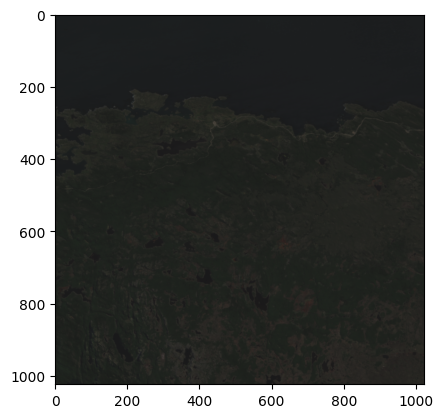

In [202]:
dataset[150]
imshow(dataset.current_image, False) # the current image state of dataset is unnormalized

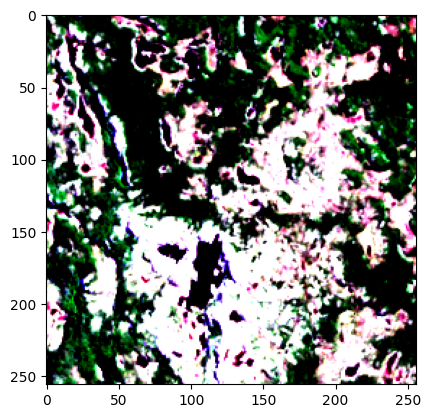

In [201]:
imshow(dataset[151]) # this is normalized

With S1RTC

In [193]:
S2L2A_metadata = '/content/drive/MyDrive/Preparing Dataset/metadata_S2L2A_with_forest_ratio.parquet'
S1RTC_metadata = '/content/drive/MyDrive/Preparing Dataset/metadata_S1RTC_with_forest_ratio.parquet'
dataset = MajorTOMDataset(
    S2L2A_metadata_path=S2L2A_metadata,
    S1RTC_metadata_path=S1RTC_metadata,
    min_forest_ratio=0.5,
    max_cloud_cover=0.1,
    use_S1RTC=True,
    n_sample_splits=4,
    normalize=True
)

<ipython-input-186-cfd167b30e87>:145: UserWarning: The S1-RTC has data available for fewer grid cells than the S2-L2A dataset. Using the S1-RTC for training would waste over 780k grid cells over the globe.
  warnings.warn("The S1-RTC has data available for fewer grid cells than the S2-L2A dataset. Using the S1-RTC for training would waste over 780k grid cells over the globe.")


Number of grid cells 204976 
Final Dataset Size:  3279616


In [194]:
import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout


In [195]:
# Access a sample from the dataset
with HiddenPrints():
  sample = dataset[32]

# Print the shape of the sample
print(sample.shape)

torch.Size([22, 256, 256])


In [196]:
import cv2
import matplotlib.pyplot as plt
def imshow_single_band(sample, band):
  img = sample[band].cpu().numpy()
  img = img.clip(0, 1)
  plt.clf()
  plt.imshow(img)

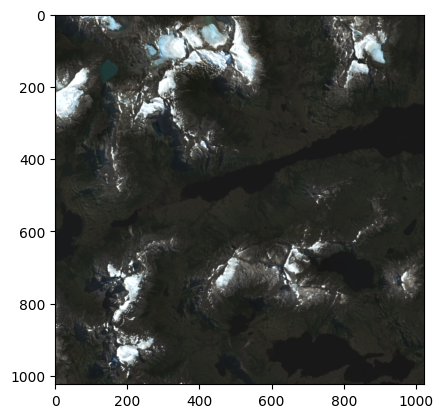

In [197]:
dataset[3]
imshow(dataset.current_image, False) # the current_image state of dataset is unnormalized

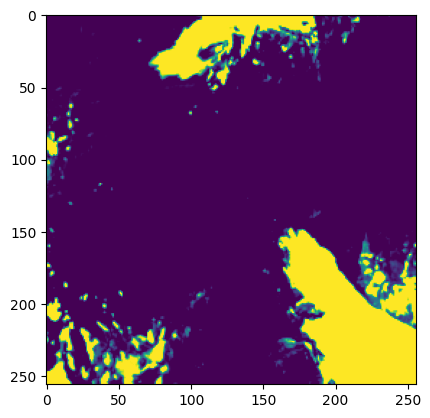

In [198]:
dataset[0]
imshow_single_band(dataset[0], 1)

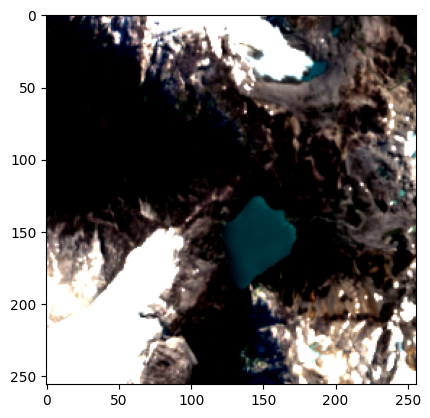

In [199]:
imshow(dataset[0]) # this is normalized

## **Training model Demo**

In [213]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Assuming you have already defined your model architecture (e.g., a CNN)
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.pool1 = nn.MaxPool2d(kernel_size=4)
        self.pool2 = nn.MaxPool2d(kernel_size=4)
        self.fc1 = nn.Linear(22 * 16 * 16, 16)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(16, num_classes)

    def forward(self, x):
        x = self.pool1(x)
        x = self.pool2(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x


# Define hyperparameters
num_epochs = 10
batch_size = 16  # Adjust based on your n_sample_splits
learning_rate = 0.001
num_classes = 2  # Example: Binary classification (forest/not forest)

# Create an instance of your model
model = SimpleCNN(num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [214]:
import torchsummary
torchsummary.summary(model, (22, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         MaxPool2d-1           [-1, 22, 64, 64]               0
         MaxPool2d-2           [-1, 22, 16, 16]               0
            Linear-3                   [-1, 16]          90,128
              ReLU-4                   [-1, 16]               0
            Linear-5                    [-1, 2]              34
Total params: 90,162
Trainable params: 90,162
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 5.50
Forward/backward pass size (MB): 0.73
Params size (MB): 0.34
Estimated Total Size (MB): 6.57
----------------------------------------------------------------


In [203]:
S2L2A_metadata = '/content/drive/MyDrive/Preparing Dataset/metadata_S2L2A_with_forest_ratio.parquet'
S1RTC_metadata = '/content/drive/MyDrive/Preparing Dataset/metadata_S1RTC_with_forest_ratio.parquet'
dataset = MajorTOMDataset(
    S2L2A_metadata_path=S2L2A_metadata,
    S1RTC_metadata_path=S1RTC_metadata,
    min_forest_ratio=0.5,
    max_cloud_cover=0.1,
    use_S1RTC=True, # decreases speed
    n_sample_splits=4,
    # bands=[i for i in range(20)], # Example: Use only Sentinel-2 bands and vegetation indices
    normalize=True
)

<ipython-input-186-cfd167b30e87>:145: UserWarning: The S1-RTC has data available for fewer grid cells than the S2-L2A dataset. Using the S1-RTC for training would waste over 780k grid cells over the globe.
  warnings.warn("The S1-RTC has data available for fewer grid cells than the S2-L2A dataset. Using the S1-RTC for training would waste over 780k grid cells over the globe.")


Number of grid cells 204976 
Final Dataset Size:  3279616


In [216]:
dataset.verbose = False

In [206]:
! rm -r ./data/S2L2A/*

In [207]:
! rm -r ./data/S1RTC/*

In [217]:
# This seems enough to parallelize loading so that the bottle neck is actually the training instead of data fetching for larger models.
# KNOWN ISSUE: Paralellization doesn't work with
train_loader = DataLoader(dataset, batch_size=batch_size, num_workers=2, shuffle = False, sampler=torch.utils.data.SequentialSampler(dataset))
# Training loop
for epoch in tqdm(range(num_epochs)):
    for i, images in tqdm(enumerate(train_loader)):
        # Forward pass

        print("Training on batch")
        outputs = model(images)
        print("Trained on batch") # to check bottleneck

        # Assuming you have labels for your data
        labels = torch.randint(0, num_classes, (images.shape[0],))  # Placeholder labels
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')

print("Training finished!")

  0%|          | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:03,  3.92s/it]

Training on batch
Trained on batch



2it [00:07,  4.01s/it]

Training on batch
Trained on batch



3it [00:11,  3.80s/it]

Training on batch
Trained on batch



4it [00:15,  3.68s/it]

Training on batch
Trained on batch
Training on batch
Trained on batch



5it [00:20,  4.23s/it]
6it [00:25,  4.49s/it]

Training on batch
Trained on batch



7it [00:29,  4.47s/it]

Training on batch
Trained on batch



8it [00:35,  4.93s/it]

Training on batch
Trained on batch



9it [00:40,  4.81s/it]

Training on batch
Trained on batch



10it [00:44,  4.52s/it]

Training on batch
Trained on batch
Epoch [1/10], Step [10/204976], Loss: 0.7139



11it [00:50,  5.04s/it]

Training on batch
Trained on batch



12it [00:54,  4.83s/it]

Training on batch
Trained on batch



13it [00:58,  4.68s/it]

Training on batch
Trained on batch



14it [01:03,  4.75s/it]

Training on batch
Trained on batch



15it [01:08,  4.74s/it]

Training on batch
Trained on batch



16it [01:13,  4.74s/it]

Training on batch
Trained on batch


16it [01:16,  4.81s/it]
  0%|          | 0/10 [01:16<?, ?it/s]


KeyboardInterrupt: 